In [1]:
from astropy.io import fits
from astropy import units, constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
from voigt_fit_lib import *
import os
import pickle

Load in the files

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/'

Then, the FUV files

In [3]:
spec_fits_fuv = fits.open(rootdir + 'FUV/PG1522+101_FUV_wavecal_new.fits')
lsf_fits_fuv = fits.open(rootdir + 'FUV/PG1522_COS_FUV_wavcal2022_lsf_ZQ.fits')

Transition info

In [4]:
wav0_rest = 1548.2049
f = 0.1899
gamma = 0.040903573458000005
A = 12.011

In [5]:
wav = pd.DataFrame(spec_fits_fuv[1].data).to_numpy()[:,0]

Functions

In [6]:
def grab_ion_transition_lsf(z_abs):

    # Convert it to an array
    lsf_data = np.array(lsf_fits_fuv[1].data)

    # For each wavelength, isolate LSFs
    lsf_wavs = []

    for i in range(len(lsf_data)):
        lsf_wavs.append(lsf_data[i][0])

    lsf_wavs = np.array(lsf_wavs)

    # Isolate the closest LSF
    lsf_idx = np.argmin(np.abs(wav0_rest*(1+z_abs)-lsf_wavs))
    lsf = lsf_data[lsf_idx][2]

    # Also generate the velocity scale corresponding to the LSF
    delta_v = lsf_data[lsf_idx][1]
    lsf_central_idx = np.argmax(lsf)
    lsf_pix_rel = np.arange(0, len(lsf))-lsf_central_idx
    lsf_pix_v = delta_v*lsf_pix_rel

    # Finally store the LSF velocities and the profile itself
    return lsf, lsf_pix_v

In [7]:
def vp(z_abs, params, lsf_convolve=True):
    
    # Grab LSF
    lsf, lsf_pix_v = grab_ion_transition_lsf(z_abs)
    
    # Get velocities
    wav0_obs = wav0_rest*(1+z_abs)
    v = c*(wav-wav0_obs)/wav0_obs
    idx = (v>=-300)&(v<=300)
    v = v[idx]
    
    model = comp_model_spec_gen(v, params, 
                                wav0_rest, f, gamma, A,
                                True,
                                lsf, lsf_pix_v)[1]
    
    return v, model

# J0155-0857, $z=0.00547$

In [8]:
z_sys = 0.00547

In [9]:
v, m = vp(z_sys, [[13.78,34,-38],[13.02, 16, 27]])

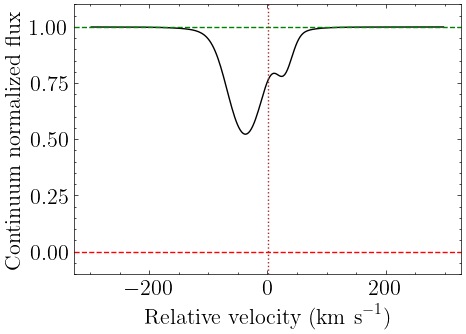

In [10]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

Compute equivalent width

In [11]:
def get_EW(v, flux, v_min=-200, v_max=200):

    idx = (v>v_min)&(v<v_max)

    v_abs = v[idx]
    flux_abs = flux[idx][:-1]

    delta_lambda = np.mean(((v_abs[1:]-v_abs[:-1])*wav0_rest/3e+5)*1e+3) # in mA

    EW = np.sum((1-flux_abs)*delta_lambda)

    return EW

In [12]:
get_EW(v, m)/1000

0.2225759257827388

Do a monte carlo computation

In [13]:
N_trials = 1000
params_grid = np.zeros((N_trials, 2*3))

Generate parameter realizations 

In [14]:
logN_c1 = np.random.normal(13.78, 0.07, N_trials)
b_c1 = np.random.normal(34, 9, N_trials)
v_c1 = np.random.normal(-38, 6, N_trials)

logN_c2 = np.random.normal(13.02, 0.32, N_trials)
b_c2 = np.random.normal(16, 19, N_trials)
b_c2[b_c2<0] = 0
v_c2 = np.random.normal(27, 11, N_trials)

Store in the grid

In [15]:
params_grid[:,0] = logN_c1
params_grid[:,1] = b_c1
params_grid[:,2] = v_c1

params_grid[:,3] = logN_c2
params_grid[:,4] = b_c2
params_grid[:,5] = v_c2

Check a realization to ensure numbers are stored correctly

In [16]:
params_grid[0,:].reshape(2,3)

array([[ 13.67392293,  33.12545003, -38.18384598],
       [ 13.51076593,  19.52005965,  35.04983679]])

In [17]:
model_grid = []

for i in range(N_trials):
    model_grid.append(vp(z_sys, params_grid[i,:].reshape(2,3))[1])
    
model_grid = np.array(model_grid)

In [18]:
model_hi = np.percentile(model_grid, 100*cdf_1sig, axis=0)
model_lo = np.percentile(model_grid, 100*(1-cdf_1sig), axis=0)

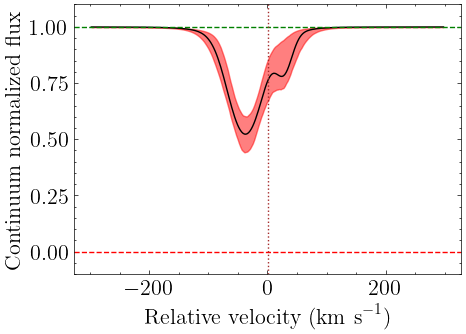

In [19]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)
ax.fill_between(v, model_lo, model_hi, color='red', alpha=.5)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

Get EW distribution

In [20]:
EW_dist = np.zeros(N_trials)

for i in range(N_trials):
    EW_dist[i] = get_EW(v, model_grid[i,:])/1000

In [24]:
(np.round(np.median(EW_dist),3), 
np.round(np.median(EW_dist)-np.percentile(EW_dist, 100*(1-cdf_1sig)),3), 
np.round(np.percentile(EW_dist, 100*cdf_1sig)-np.median(EW_dist),3))

(0.213, 0.036, 0.045)

# J0242-0759, $z=0.00477$

In [25]:
z_sys = 0.00477

In [26]:
v, m = vp(z_sys, [[13.81,39,-23]])

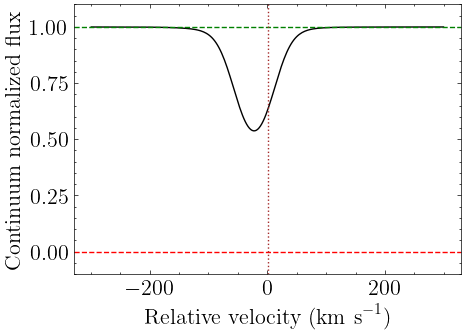

In [27]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [28]:
get_EW(v, m)/1000

0.2039369722046327

In [29]:
N_trials = 1000
params_grid = np.zeros((N_trials, 1*3))

In [30]:
logN_c1 = np.random.normal(13.81, 0.08, N_trials)
b_c1 = np.random.normal(39, 10, N_trials)
v_c1 = np.random.normal(-23, 6, N_trials)

In [31]:
params_grid[:,0] = logN_c1
params_grid[:,1] = b_c1
params_grid[:,2] = v_c1

In [35]:
params_grid[2,:].reshape(1,3)

array([[ 13.8167272 ,  41.98838869, -19.66741901]])

In [36]:
model_grid = []

for i in range(N_trials):
    model_grid.append(vp(z_sys, params_grid[i,:].reshape(1,3))[1])
    
model_grid = np.array(model_grid)

In [37]:
model_hi = np.percentile(model_grid, 100*cdf_1sig, axis=0)
model_lo = np.percentile(model_grid, 100*(1-cdf_1sig), axis=0)

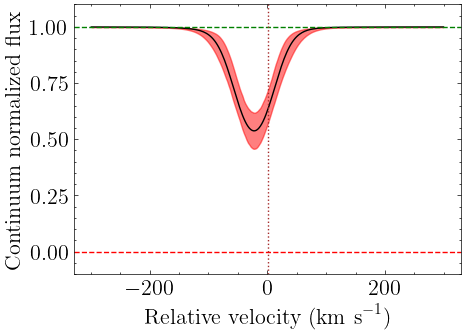

In [38]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)
ax.fill_between(v, model_lo, model_hi, color='red', alpha=.5)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [39]:
EW_dist = np.zeros(N_trials)

for i in range(N_trials):
    EW_dist[i] = get_EW(v, model_grid[i,:])/1000

In [40]:
(np.round(np.median(EW_dist),3), 
np.round(np.median(EW_dist)-np.percentile(EW_dist, 100*(1-cdf_1sig)),3), 
np.round(np.percentile(EW_dist, 100*cdf_1sig)-np.median(EW_dist),3))

(0.2, 0.028, 0.034)

# J0925+4004, $z=0.00261$

In [41]:
z_sys = 0.00261

In [42]:
v, m = vp(z_sys, [[14.19,34,9]])

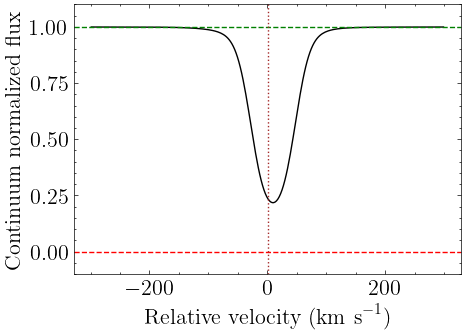

In [43]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [44]:
get_EW(v, m)/1000

0.3458646128195711

In [45]:
N_trials = 1000
params_grid = np.zeros((N_trials, 1*3))

In [46]:
logN_c1 = np.random.normal(14.19, 0.07, N_trials)
b_c1 = np.random.normal(34, 6, N_trials)
v_c1 = np.random.normal(9, 4, N_trials)

In [47]:
params_grid[:,0] = logN_c1
params_grid[:,1] = b_c1
params_grid[:,2] = v_c1

In [48]:
params_grid[2,:].reshape(1,3)

array([[14.13899058, 31.85365227,  7.30421135]])

In [49]:
model_grid = []

for i in range(N_trials):
    model_grid.append(vp(z_sys, params_grid[i,:].reshape(1,3))[1])
    
model_grid = np.array(model_grid)

In [50]:
model_hi = np.percentile(model_grid, 100*cdf_1sig, axis=0)
model_lo = np.percentile(model_grid, 100*(1-cdf_1sig), axis=0)

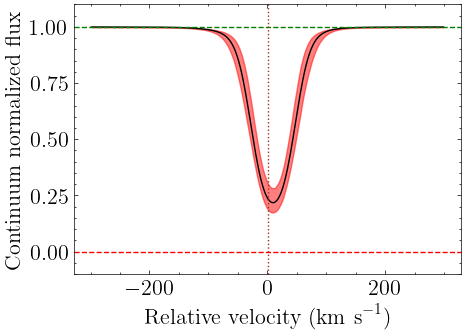

In [51]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)
ax.fill_between(v, model_lo, model_hi, color='red', alpha=.5)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [52]:
EW_dist = np.zeros(N_trials)

for i in range(N_trials):
    EW_dist[i] = get_EW(v, model_grid[i,:])/1000

In [53]:
(np.round(np.median(EW_dist),3), 
np.round(np.median(EW_dist)-np.percentile(EW_dist, 100*(1-cdf_1sig)),3), 
np.round(np.percentile(EW_dist, 100*cdf_1sig)-np.median(EW_dist),3))

(0.34, 0.038, 0.042)

# J0928+6025, $z=0.01494$

In [54]:
z_sys = 0.01494

In [55]:
v, m = vp(z_sys, [[13.77,25,-23]])

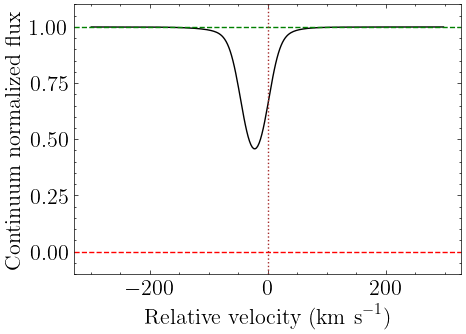

In [56]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [57]:
get_EW(v, m)/1000

0.16972082407766206

In [58]:
N_trials = 1000
params_grid = np.zeros((N_trials, 1*3))

In [59]:
logN_c1 = np.random.normal(13.77, 0.03, N_trials)
b_c1 = np.random.normal(25, 3, N_trials)
v_c1 = np.random.normal(-23, 2, N_trials)

In [60]:
params_grid[:,0] = logN_c1
params_grid[:,1] = b_c1
params_grid[:,2] = v_c1

In [62]:
params_grid[2,:].reshape(1,3)

array([[ 13.76016369,  26.66666996, -23.15768697]])

In [63]:
model_grid = []

for i in range(N_trials):
    model_grid.append(vp(z_sys, params_grid[i,:].reshape(1,3))[1])
    
model_grid = np.array(model_grid)

In [64]:
model_hi = np.percentile(model_grid, 100*cdf_1sig, axis=0)
model_lo = np.percentile(model_grid, 100*(1-cdf_1sig), axis=0)

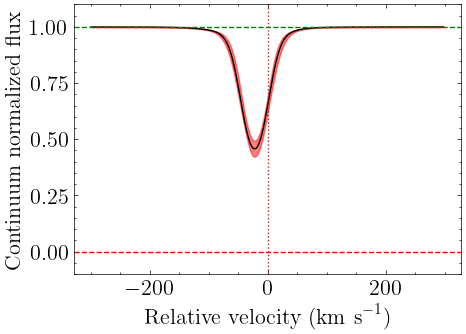

In [65]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)
ax.fill_between(v, model_lo, model_hi, color='red', alpha=.5)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [66]:
EW_dist = np.zeros(N_trials)

for i in range(N_trials):
    EW_dist[i] = get_EW(v, model_grid[i,:])/1000

In [67]:
(np.round(np.median(EW_dist),3), 
np.round(np.median(EW_dist)-np.percentile(EW_dist, 100*(1-cdf_1sig)),3), 
np.round(np.percentile(EW_dist, 100*cdf_1sig)-np.median(EW_dist),3))

(0.17, 0.011, 0.01)

# J1059+1441, $z=0.00242$

In [68]:
z_sys = 0.00242

In [69]:
v, m = vp(z_sys, [[14.06,20,-6]])

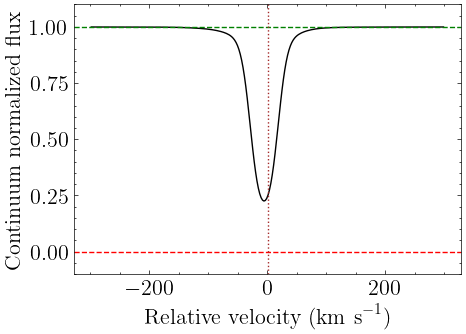

In [70]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [71]:
get_EW(v, m)/1000

0.22763935421730844

In [72]:
N_trials = 1000
params_grid = np.zeros((N_trials, 1*3))

In [73]:
logN_c1 = np.random.normal(14.06, 0.04, N_trials)
b_c1 = np.random.normal(20, 2, N_trials)
v_c1 = np.random.normal(-6, 1, N_trials)

In [74]:
params_grid[:,0] = logN_c1
params_grid[:,1] = b_c1
params_grid[:,2] = v_c1

In [75]:
params_grid[2,:].reshape(1,3)

array([[14.08607892, 20.29845643, -6.5486231 ]])

In [76]:
model_grid = []

for i in range(N_trials):
    model_grid.append(vp(z_sys, params_grid[i,:].reshape(1,3))[1])
    
model_grid = np.array(model_grid)

In [77]:
model_hi = np.percentile(model_grid, 100*cdf_1sig, axis=0)
model_lo = np.percentile(model_grid, 100*(1-cdf_1sig), axis=0)

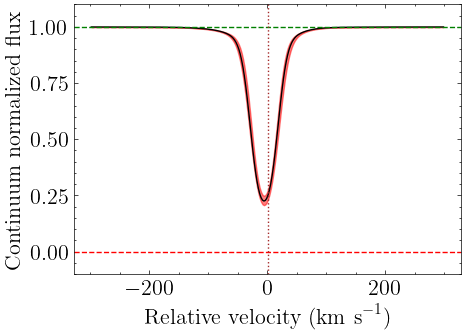

In [78]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)
ax.fill_between(v, model_lo, model_hi, color='red', alpha=.5)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [79]:
EW_dist = np.zeros(N_trials)

for i in range(N_trials):
    EW_dist[i] = get_EW(v, model_grid[i,:])/1000

In [80]:
(np.round(np.median(EW_dist),3), 
np.round(np.median(EW_dist)-np.percentile(EW_dist, 100*(1-cdf_1sig)),3), 
np.round(np.percentile(EW_dist, 100*cdf_1sig)-np.median(EW_dist),3))

(0.227, 0.016, 0.016)

# J1122+5755, $z=0.00640$

In [81]:
z_sys = 0.00640

In [82]:
v, m = vp(z_sys, [[14.33,24,21]])

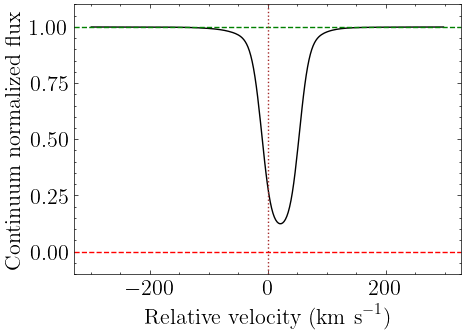

In [83]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [84]:
get_EW(v, m)/1000

0.32415450863423423

In [85]:
N_trials = 1000
params_grid = np.zeros((N_trials, 1*3))

In [86]:
logN_c1 = np.random.normal(14.33, 0.07, N_trials)
b_c1 = np.random.normal(24, 3, N_trials)
v_c1 = np.random.normal(21, 2, N_trials)

In [87]:
params_grid[:,0] = logN_c1
params_grid[:,1] = b_c1
params_grid[:,2] = v_c1

In [90]:
params_grid[1,:].reshape(1,3)

array([[14.28811774, 23.08767142, 21.93142992]])

In [91]:
model_grid = []

for i in range(N_trials):
    model_grid.append(vp(z_sys, params_grid[i,:].reshape(1,3))[1])
    
model_grid = np.array(model_grid)

In [92]:
model_hi = np.percentile(model_grid, 100*cdf_1sig, axis=0)
model_lo = np.percentile(model_grid, 100*(1-cdf_1sig), axis=0)

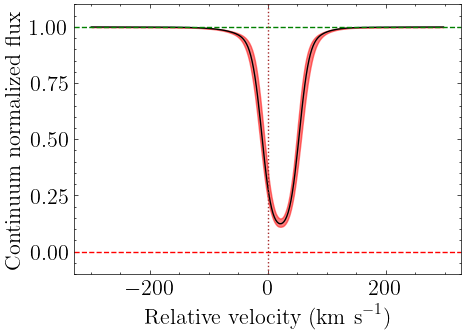

In [93]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)
ax.fill_between(v, model_lo, model_hi, color='red', alpha=.5)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [94]:
EW_dist = np.zeros(N_trials)

for i in range(N_trials):
    EW_dist[i] = get_EW(v, model_grid[i,:])/1000

In [95]:
(np.round(np.median(EW_dist),3), 
np.round(np.median(EW_dist)-np.percentile(EW_dist, 100*(1-cdf_1sig)),3), 
np.round(np.percentile(EW_dist, 100*cdf_1sig)-np.median(EW_dist),3))

(0.323, 0.032, 0.033)

# J1233-0031, $z=0.00392$

In [96]:
z_sys = 0.00392

In [97]:
v, m = vp(z_sys, [[13.59,13,-22]])

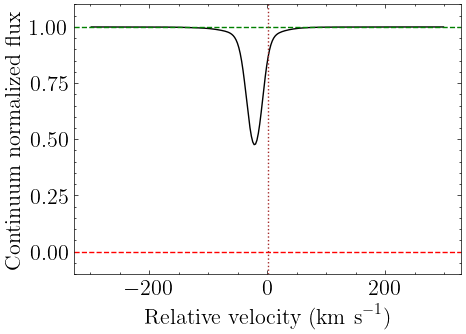

In [98]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [99]:
get_EW(v, m)/1000

0.10363748438369026

In [100]:
N_trials = 1000
params_grid = np.zeros((N_trials, 1*3))

In [101]:
logN_c1 = np.random.normal(13.59, 0.09, N_trials)
b_c1 = np.random.normal(13, 4, N_trials)
b_c1[b_c1<0] = 0
v_c1 = np.random.normal(-22, 3, N_trials)

In [102]:
params_grid[:,0] = logN_c1
params_grid[:,1] = b_c1
params_grid[:,2] = v_c1

In [104]:
params_grid[0,:].reshape(1,3)

array([[ 13.64691209,  14.38310983, -21.12455538]])

In [105]:
model_grid = []

for i in range(N_trials):
    model_grid.append(vp(z_sys, params_grid[i,:].reshape(1,3))[1])
    
model_grid = np.array(model_grid)

In [106]:
model_hi = np.percentile(model_grid, 100*cdf_1sig, axis=0)
model_lo = np.percentile(model_grid, 100*(1-cdf_1sig), axis=0)

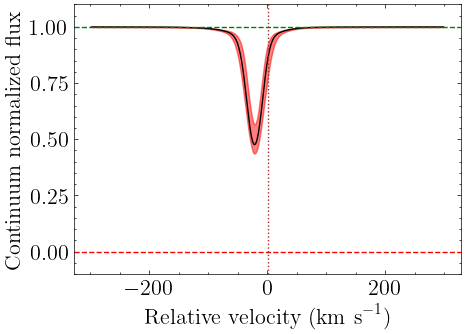

In [107]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)
ax.fill_between(v, model_lo, model_hi, color='red', alpha=.5)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [108]:
EW_dist = np.zeros(N_trials)

for i in range(N_trials):
    EW_dist[i] = get_EW(v, model_grid[i,:])/1000

In [109]:
(np.round(np.median(EW_dist),3), 
np.round(np.median(EW_dist)-np.percentile(EW_dist, 100*(1-cdf_1sig)),3), 
np.round(np.percentile(EW_dist, 100*cdf_1sig)-np.median(EW_dist),3))

(0.102, 0.018, 0.019)

# J1445+3428, $z=0.00549$

In [110]:
z_sys = 0.00549

In [111]:
v, m = vp(z_sys, [[14.15,17,13]])

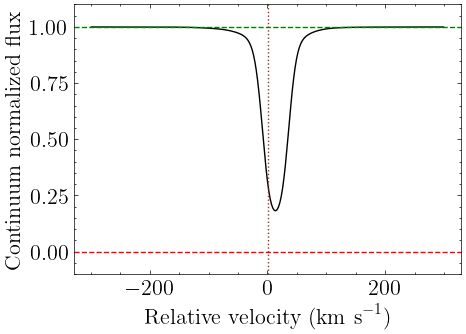

In [112]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [113]:
get_EW(v, m)/1000

0.22424618084947978

In [114]:
N_trials = 1000
params_grid = np.zeros((N_trials, 1*3))

In [115]:
logN_c1 = np.random.normal(14.15, 0.13, N_trials)
b_c1 = np.random.normal(17, 4, N_trials)
b_c1[b_c1<0] = 0
v_c1 = np.random.normal(13, 3, N_trials)

In [116]:
params_grid[:,0] = logN_c1
params_grid[:,1] = b_c1
params_grid[:,2] = v_c1

In [121]:
params_grid[5,:].reshape(1,3)

array([[14.06223971, 10.99664165,  9.44953976]])

In [122]:
model_grid = []

for i in range(N_trials):
    model_grid.append(vp(z_sys, params_grid[i,:].reshape(1,3))[1])
    
model_grid = np.array(model_grid)

In [123]:
model_hi = np.percentile(model_grid, 100*cdf_1sig, axis=0)
model_lo = np.percentile(model_grid, 100*(1-cdf_1sig), axis=0)

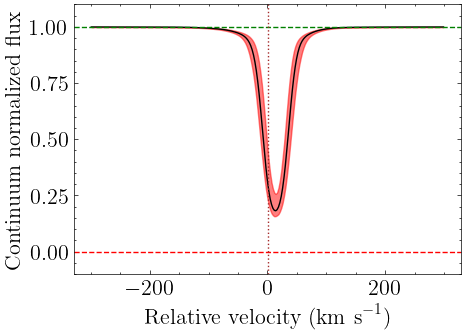

In [124]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)
ax.fill_between(v, model_lo, model_hi, color='red', alpha=.5)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [125]:
EW_dist = np.zeros(N_trials)

for i in range(N_trials):
    EW_dist[i] = get_EW(v, model_grid[i,:])/1000

In [126]:
(np.round(np.median(EW_dist),3), 
np.round(np.median(EW_dist)-np.percentile(EW_dist, 100*(1-cdf_1sig)),3), 
np.round(np.percentile(EW_dist, 100*cdf_1sig)-np.median(EW_dist),3))

(0.219, 0.039, 0.043)

# PG1148+549, $z=0.00349$

In [127]:
z_sys = 0.00349

In [128]:
v, m = vp(z_sys, [[13.66,11,-10]])

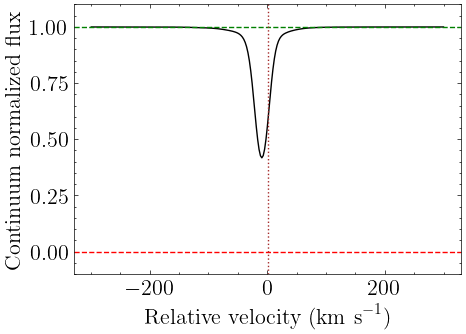

In [129]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [130]:
get_EW(v, m)/1000

0.10657473536260295

In [131]:
N_trials = 1000
params_grid = np.zeros((N_trials, 1*3))

In [132]:
logN_c1 = np.random.normal(13.66, 0.03, N_trials)
b_c1 = np.random.normal(11, 1, N_trials)
v_c1 = np.random.normal(-10, 1, N_trials)

In [133]:
params_grid[:,0] = logN_c1
params_grid[:,1] = b_c1
params_grid[:,2] = v_c1

In [135]:
params_grid[0,:].reshape(1,3)

array([[ 13.63762441,  10.06380066, -10.50088993]])

In [136]:
model_grid = []

for i in range(N_trials):
    model_grid.append(vp(z_sys, params_grid[i,:].reshape(1,3))[1])
    
model_grid = np.array(model_grid)

In [137]:
model_hi = np.percentile(model_grid, 100*cdf_1sig, axis=0)
model_lo = np.percentile(model_grid, 100*(1-cdf_1sig), axis=0)

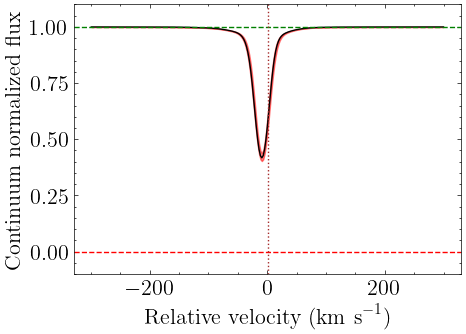

In [138]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)
ax.fill_between(v, model_lo, model_hi, color='red', alpha=.5)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [139]:
EW_dist = np.zeros(N_trials)

for i in range(N_trials):
    EW_dist[i] = get_EW(v, model_grid[i,:])/1000

In [140]:
(np.round(np.median(EW_dist),3), 
np.round(np.median(EW_dist)-np.percentile(EW_dist, 100*(1-cdf_1sig)),3), 
np.round(np.percentile(EW_dist, 100*cdf_1sig)-np.median(EW_dist),3))

(0.106, 0.006, 0.006)

# Upper limits

In [150]:
df = pd.read_csv('/Users/thepoetoftwilight/Documents/CUBS/Data/burchett_upper_lims.csv')
df.columns = ['d_proj', 'logN_lim']

In [157]:
d_proj = np.array(df['d_proj'])
logN_lim = np.array(df['logN_lim'])

In [168]:
EW_lim = np.zeros(len(logN_lim))

for i in range(len(EW_lim)):
    v, m = vp(0.007, [[logN_lim[i],10,0]])
    EW_lim[i] = get_EW(v, m)/1000

<ErrorbarContainer object of 3 artists>

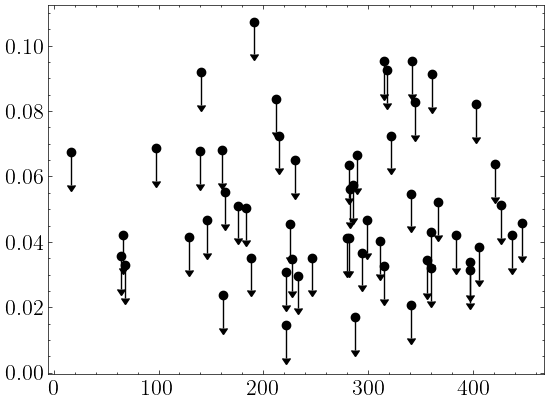

In [176]:
plt.errorbar(d_proj, EW_lim, yerr=0.01, uplims=True, linestyle='none', marker='o')

In [187]:
df['d_proj'] = np.int_(np.round(d_proj))
df['EW_lim'] = ['<'+str(np.round(EW,2)) for EW in EW_lim]

In [189]:
df[['d_proj','EW_lim']]

,d_proj,EW_lim
0,16,<0.07
1,68,<0.03
2,64,<0.04
3,66,<0.04
4,98,<0.07
5,129,<0.04
6,140,<0.07
7,140,<0.09
8,160,<0.07
9,147,<0.05
